In [1]:
# Necesario para un exportado lindo a html
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Esconder/mostrar código"></form>''')

In [3]:
# Load defunciones
%matplotlib inline
import pandas as pd
import json, os

# Locals v/s floydhub
if 'TERM_PROGRAM' in os.environ:
    input_path = '../datasets/defunciones-decoded/'
else:
    input_path = '/floyd/input/defunciones/'

# Dtypes
# Load dtypes from json
with open(input_path + 'dtypes.json') as json_data:
    read_dtypes = json.load(json_data)
date_fields = []

# Capture datetime fields
for col in read_dtypes:
    if read_dtypes[col] == 'datetime64[ns]':
        date_fields.append(col)
        
# Remove datetime fields
for field in date_fields:
    del read_dtypes[field]
    
defunciones = pd.read_csv(input_path + 'defunciones-deis-1998-2016-parsed-1M.csv', dtype=read_dtypes, parse_dates=date_fields,index_col=0)

# Load cie-10 codes
cie10 = pd.read_csv(input_path + 'cie-10.csv').set_index('code')
def describe_cie10_index(Series):
    tmp = pd.Series()
    for row in Series.items():
        tmp[cie10.loc[row[0]].description] = row[1]
    return tmp

# Lenguaje de programación y testeo estadístico: el caso de Ventanas
## Una comparativa entre la zona crítica y resto de Chile
### Introducción
Mediante programación en phyton es posible estandarizar en forma sencilla los registros de defunciones oficiales, que tienen una serie de variaciones año a año. Una vez construida una [unificación de los registros de defunciones en Chile, entre el año 1998 y 2016](https://github.com/verasativa/defunciones-decoder), surge la pregunta general: ¿Se podrán observar en éste, rasgos distintos en una zona crítica al resto de Chile? Con el mismo lenguaje de programación podría testearse esa hipótesis.
### Comparación de diagnósticos primarios
Apalancándose en la integración jerárquica, de los códigos de diagnóstico CIE-10 en el dataset. Una comparación de éstos, se presenta como la opción más evidente y atractiva, pero con algunas consideraciones.
### Limitaciones
Dado que este dataset solo incluye las defunciones, y no contiene información sobre la población general, no es posible hacer un análisis respecto a tasas de ocurrencia, sin tener que argumentar con otros datos como censos. Además la ruralidad de la zona, conjugada con la migración campo-ciudad, produce una población envejecida. Tampoco podemos hacer un análisis sobre la distribución etaria de la mortalidad, ni la distribución de diagnósticos primarios en la población general, sin normalizar primero con datos adicionales.
### Pregunta de investigación
Con esas limitaciones en mente, podemos plantear una pregunta sencilla, pero contestable:

__¿Como se comparan los diagnósticos primarios de defunciones, en la zona de interés con respecto al resto del país, en menores de 16 años?__

In [4]:
# Seleccionamos menores
defunciones_poblacion = defunciones.query('(age_type == "años" and age_amount <= 16) or (age_type in ["meses", "días", "horas"])')

listado_comunas = ["Quintero", "Puchuncaví", "Zapallar", "Papudo", "La Ligua", "Concón"]

defunciones_test = defunciones_poblacion.query('comune in @listado_comunas') # Menores en zona de interes
defunciones_control = defunciones_poblacion.query('comune not in @listado_comunas') # Menores resto de Chile (control)

__Algunos datos sobre los grupos:__

In [5]:
print('Total defunciones en el grupo de interés: {}'.format(defunciones_test.shape[0]))
top_n = 10
print('Total defunciones en los {} principales diagnósticos primarios del grupo de interés: {}'.format(
    top_n,
    defunciones_test.primary_code_0.value_counts()[:top_n].sum()
))
print('Fracción del total: {0:.3f}'.format(defunciones_test.primary_code_0.value_counts()[:top_n].sum()/defunciones_test.shape[0]))

Total defunciones en el grupo de interés: 326
Total defunciones en los 10 principales diagnósticos primarios del grupo de interés: 319
Fracción del total: 0.979


In [6]:
print('Total defunciones en el grupo de control: {}'.format(defunciones_control.shape[0]))
top_n = 10
print('Total defunciones en los {} principales diagnósticos primarios del grupo de control: {}'.format(
    top_n,
    defunciones_control.primary_code_0.value_counts()[:top_n].sum()
))
print('Fracción del total: {0:.3f}'.format(defunciones_control.primary_code_0.value_counts()[:top_n].sum()/defunciones_control.shape[0]))

Total defunciones en el grupo de control: 57785
Total defunciones en los 10 principales diagnósticos primarios del grupo de control: 56422
Fracción del total: 0.976


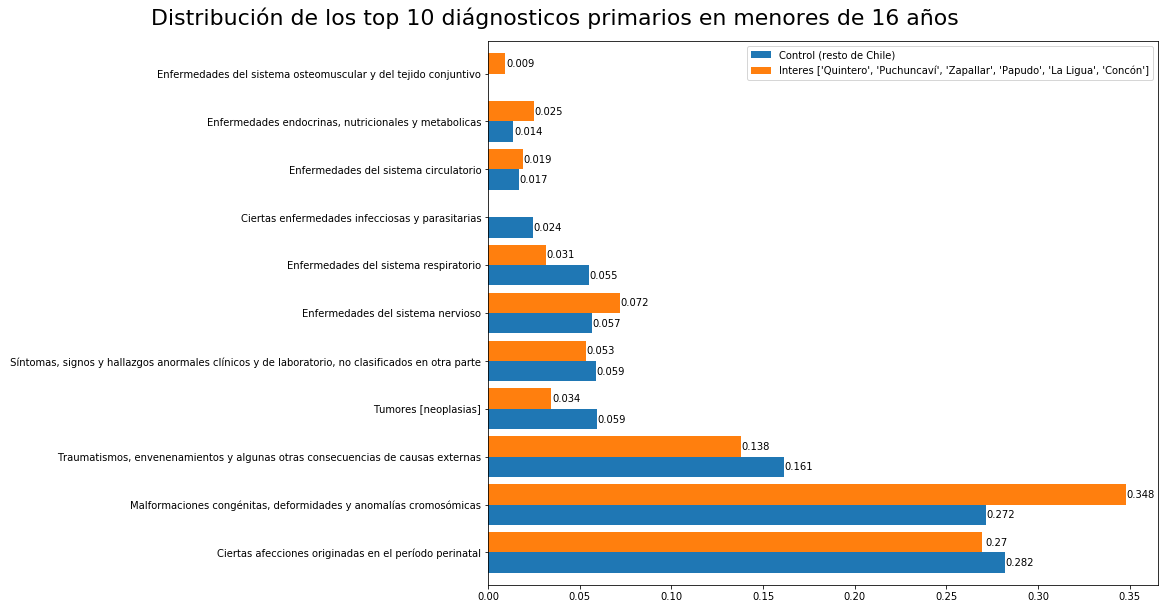

In [7]:
# Los x diágnosticos primarios mayores en control
incidencias_control = pd.DataFrame(describe_cie10_index(defunciones_control.primary_code_0.value_counts()[:top_n]), columns=['Control'])
# Los x diágnosticos primarios mayores en interés
incidencias_test = pd.DataFrame(describe_cie10_index(defunciones_test.primary_code_0.value_counts()[:top_n]), columns=['Interés'])
# Concatenamos
comparativa = pd.concat([incidencias_control, incidencias_test], axis=1, sort=False)
# A fracción
comparativa['Control (resto de Chile)'] = comparativa.Control / comparativa.Control.sum()
comparativa['Interes {}'.format(listado_comunas)] = comparativa.Interés / comparativa.Interés.sum()
del comparativa['Control']
del comparativa['Interés']
ax = comparativa.plot(kind='barh',
                      figsize=(12,10),
                      width=.85)
ax.set_title('Distribución de los top {} diágnosticos primarios en menores de 16 años'.format(top_n), size=22, y=1.02, x=.1)
import numpy as np
for p in ax.patches:
    if p.get_width() != 0:
        ax.annotate(np.round(p.get_width(),decimals=3), 
                    (p.get_width()+.008, p.get_y()),
                    ha='center',
                    va='center',
                    xytext=(0, 10),
                    textcoords='offset points')

from matplotlib import pyplot as mp
mp.savefig('assets/10diagnosticos.png', bbox_inches='tight')

## Observaciones
Al comparar estos gráficos, inmediatamente notamos que el diagnostico primario "Malformaciones congénitas, deformidades y anomalías cromosómicas" (CIE-10: Q00-Q99), es considerablemente más alto en el grupo de interés, por sobre el grupo de control (34.8% por sobre 27.2%).
## Validación
Para validar esta observación, realizaremos una prueba de permutación:

Tomamos 1.000.000 de muestras del mismo tamaño que el grupo de interés (326) desde el grupo de control, y observaremos la distribución del diagnostico primario de interés en estas muestras, a fin de responder:

__¿Qué tan probable es observar la incidencia (34.8%) que se da nuestro grupo de interés, en cualquier otro grupo del mismo tamaño muestreado al azar desde el grupo de control?__ (azar en contraste con casos seleccionados por zona geográfica de interés)

In [9]:
from tqdm.auto import tqdm
sample_size = defunciones_test.shape[0] # 326
n_simulaciones = 10 ** 6
simulaciones = []
for i in tqdm(range(n_simulaciones), unit='muestras'):
    sample = defunciones_control.sample(n=sample_size).primary_code_0.value_counts()[:top_n]
    simulaciones.append(sample['Q00-Q99']/sample.sum()) # Malformaciones congénitas, deformidades y anomalías cromosómicas
simulaciones = pd.DataFrame(simulaciones, columns=['fraccion'])
simulaciones.to_pickle('simulaciones{}.pk'.format(n_simulaciones))

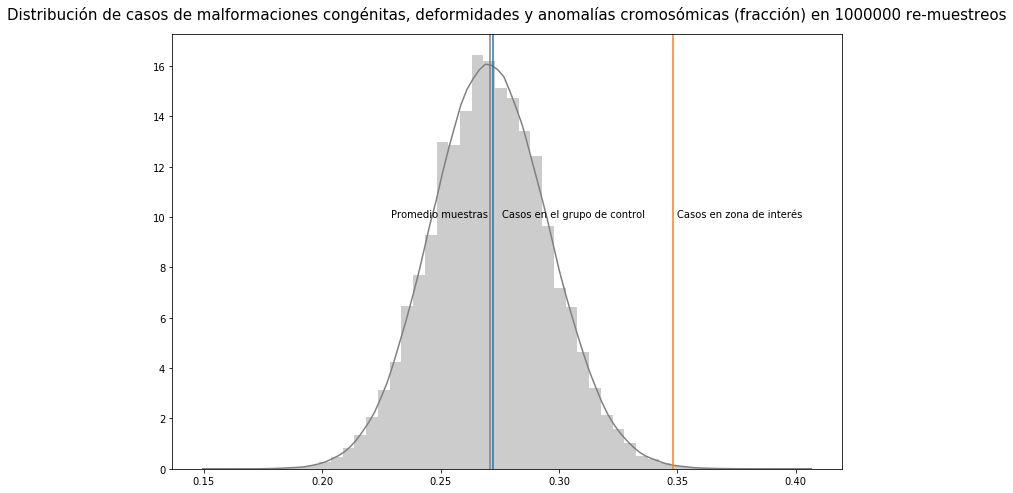

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

title = 'Distribución de casos de malformaciones congénitas, deformidades y anomalías cromosómicas (fracción) en {} re-muestreos'.format(n_simulaciones)
plt.figure(figsize=(12, 8))
ax = sns.distplot(simulaciones.fraccion.values, color='grey', bins=50).set_title(title, size=15, y=1.02)
plt.axvline(.348, label="", color='tab:orange')
foo = plt.text(.35,10,'Casos en zona de interés')
plt.axvline(.272, label="")
foo = plt.text(.276,10,'Casos en el grupo de control')
plt.axvline(simulaciones.fraccion.mean(), label="", color='grey')
foo = plt.text(simulaciones.fraccion.mean()-.042, 10,'Promedio muestras')
mp.savefig('assets/distribucion.png', bbox_inches='tight')

## Otros valores de interés
El gráfico anterior, muestra que es extremadamente improbable obtener la incidencia del diagnostico primario de interés (malformaciones congénitas, deformidades y anomalías cromosómicas), que se observa la zona de interés, desde muestras del mismo tamaño tomadas al azar desde el resto de Chile.

A continuación cuantificamos la observación anterior con los siguientes números:
 - Probabilidad de obtener este resultado o más al azar (P-Value)
 - Incidencia promedio en muestras al azar desde el grupo de control
 - Desviación standard de muestras al azar desde el grupo de control
 - Cuantificación en desviaciones standards de cuanto se aleja la observación de interés desde el promedio de los 10.000 re-muestreos

In [21]:
# Probabilidad de obtener este resultado o más al azar (P-Value)
pvalue = simulaciones.query('fraccion > .348').shape[0] / simulaciones.shape[0]
print('P-value: {:.4f}'.format(pvalue))

# Promedio de muestras
promedio_muestras = simulaciones.fraccion.mean()
print('Promedio de las muestras: {:.4f}'.format(promedio_muestras))

# Desviación standar
std = simulaciones.fraccion.std()
print('Desviación standard de las muestras: {:.4f}'.format(std))

# ¿cuantas desviaciones standards se aleja?
std_delta = (.348 - simulaciones.fraccion.mean()) / simulaciones.fraccion.std()
print('Distancia entre el promedio de las muestras y el grupo de interés en desviaciones standard: {:.2f}'.format(std_delta))

P-value: 0.0011
Promedio de las muestras: 0.2709
Desviación standard de las muestras: 0.0247
Distancia entre el promedio de las muestras y el grupo de interés en desviaciones standard: 3.12


## Variaciones en el P-value
A razón de haber observado variaciones en el primer dígito no-cero del P-value en las primeras ejecuciones de 10.000 re-muestreos, se aumento la cantidad de re-muestreos en 2 ordenes de magnitud. Y para entender como se comporta este P-value respecto a la cantidad de re-muestreos, se toman sub-muestras del millón de muestras en incrementos de 500. Al graficar, el P-value en estas distintas cantidades de re-muestreos, se observa que con el n inicial de 10.000 se lograba estabilizar en su orden de magnitud (~0.01%), con un millón se logran estabilizar los primeros dos dígitos que no son cero (0.011%).

In [ ]:
p_values = pd.DataFrame()
step = 500
for n_samples in range(step, n_simulaciones, step):
    current_sample_set = simulaciones.sample(n=n_samples)
    pvalue = current_sample_set.query('fraccion > .348').shape[0] / current_sample_set.shape[0]
    data = {
        'N resamples': current_sample_set.shape[0],
        'P-value': pvalue
    }
    p_values = p_values.append(data, ignore_index=True)

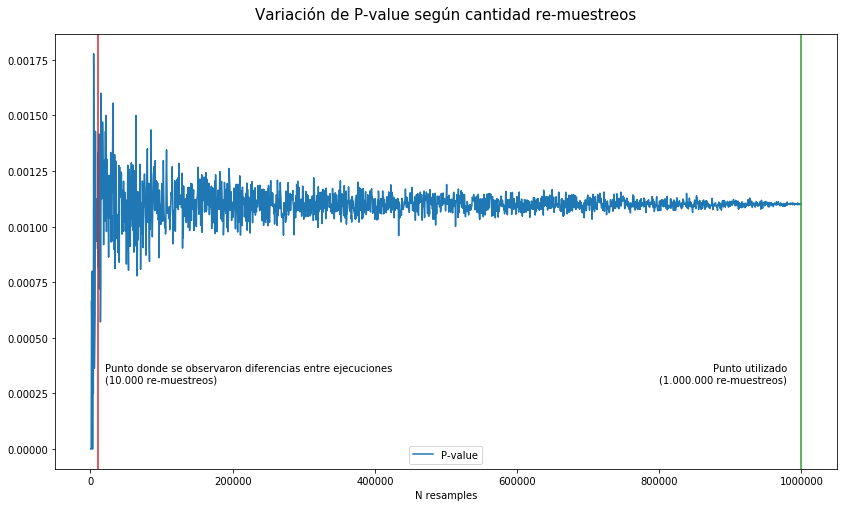

In [27]:
import matplotlib.pyplot as plt
from matplotlib import pyplot as mp
p_values.set_index('N resamples').plot(figsize=(14,8)).set_title('Variación de P-value según cantidad re-muestreos', size=15, y=1.02)

# Anotamos
plt.axvline(10000, label="", color='tab:red')
foo = plt.text(20000,.0003,'Punto donde se observaron diferencias entre ejecuciones\n(10.000 re-muestreos)')

plt.axvline(1000000, label="", color='tab:green')
foo = plt.text(980000,.0003,'Punto utilizado\n(1.000.000 re-muestreos)', horizontalalignment='right')

foo = mp.savefig('assets/variacion-p-values.png', bbox_inches='tight')

## Conclusiones
Con una posibilidad de 0.11% de encontrar el nivel de incidencia del diagnóstico _malformaciones congénitas, deformidades y anomalías cromosómicas_ (CIE-10: Q00-Q99) que se presenta en la zona de interés (34.8%) o mayor, podemos asumir que la incidencia mayor observada no es producto del azar. Correspondería a los expertos del área (salud, bioquímica, ecología, etc.) plantear rutas específicas que llevan al incremento de las defunciones bajo este diagnóstico primario. Y por otra parte a los gobernantes hacer la prueba de campo, descartando las causales en sospecha, para poder observar en algunas décadas, la evolución de la incidencia de este diagnóstico primario en las defunciones de la zona.

### Potencial futuro de la metodología
La técnica particular puede ser escalada para buscar este tipo de fenómenos a nivel nacional sin especificar una zona en particular, lo que podría revelar problemas de salud pública fuera del "radar" de los investigadores. Para esto se requeriría construir un graph con comunas como nodos, y sus colindacias geográficas como vértices (tal vez con [estos vectores](https://www.bcn.cl/siit/mapas_vectoriales/index_html)), e iterar sobre grupos de comunas colindantes con un mínimo de registros totales. De realizarse, se sugiere el nombre: _Perico_ para tal script que _treparía por Chile_
#### Contacto
Vera Sativa  
hola@verasativa.com

# Bibliografía
http://haghish.com/resources/materials/Statistical_Methods_for_Research_Workers.pdf

## Publicaciones sobre la zona:
[Spatial gradient of human health risk from exposure to trace elements and radioactive pollutants in soils at the Puchuncaví-Ventanas industrial complex, Chile.](https://www.sciencedirect.com/science/article/pii/S0269749116305693)  
_S. Salmani Ghabeshi, M.R. Palomo Marin, E. Bernalte, F. Rueda Holgado, C. Miro Rodriguez, F. Cereceda Balic, X. Fadic, V. Vidal, M. Funes, E. Pinilla Gil_  
2016, Environmental Pollution

[Representaciones sociales acerca del impacto medioambiental de las empresas termoeléctricas en la bahía de Quintero-Puchuncaví](https://summapsicologica.cl/index.php/summa/article/view/188)  
_Claudia Carrasco Aguilar, Pamela Morales Bierschwale, Jenniffer Salazar Fuentes_  
2015, Summa Psicológica

[Spatial distribution of copper and pH in soils affected by intensive industrial activities in Puchuncaví and Quintero, central Chile](http://jsspn.ufro.cl/index.php?option=com_docman&task=doc_download&gid=451&Itemid=6)  
_I. Gonzalez, A. Neaman, P. Rubio, A. Cortes_  
2014, Journal of soil science and plant nutrition

Fractionation of trace elements in total atmospheric deposition by filtrating-bulk passive sampling.  
_F. Rueda Holgado, M.R. Palomo Marin, L. Calvo Blazquez, F. Cereceda Balic, E. Pinilla Gil_  
2014, Talanta
 
Selenium and its redox speciation in rainwater from sites of Valparaiso region in Chile, impacted by mining activities of copper ores.  
_Gregori Ida De, Maria G. Lobos, Hugo Pinochet_  
2002, Water research
 
Hypo-interventions: Intimate activism in toxic environments.  
_Manuel Tironi_  
2018, Social studies of science

Proposed modification to avoidance test with Eisenia fetida to assess metal toxicity in agricultural soils affected by mining activities.  
_Victor Delgadillo, Jose Verdejo, Pedro Mondaca, Gabriela Verdugo, Hernan Gaete, Mark E. Hodson, Alexander Neaman_  
2017, Ecotoxicology and Environmental Safety
 
Distribution of trace elements in particle size fractions for contaminated soils by a copper smelting from different zones of the Puchuncaví Valley (Chile).  
_Sonnia Parra, Manuel A. Bravo, Waldo Quiroz, Teresa Moreno, Angeliki Karanasiou, Oriol Font, Victor Vidal, Francisco Cereceda_  
2014, Chemosphere
 
Effects of lime and compost on earthworm (Eisenia fetida) reproduction in copper and arsenic contaminated soils from the Puchuncaví Valley, Chile.  
_Alexander Neaman, Soledad Huerta, Sebastien Sauve_  
2012, Ecotoxicology and Environmental Safety
 
Long-term assessment of ecological risk from deposition of elemental pollutants in the vicinity of the industrial area of Puchuncaví-Ventanas, central Chile.  
_Soroush Salmanighabeshi, M. Rosario Palomo Marin, Elena Bernalte, Fernando Rueda Holgado, Conrado Miro Rodriguez, Ximena Fadic Ruiz, Victor Vidal Cortez, Francisco Cereceda Balic, Eduardo Pinilla Gil_  
2015, The Science of the total environment
 
Simultaneous immobilization of metals and arsenic in acidic polluted soils near a copper smelter in central Chile.  
_Valeska Carcamo, Elena Bustamante, Elizabeth Trangolao, Luz Maria De La Fuente, Michel Mench, Alexander Neaman, Rosanna Ginocchio_  
2012, Environmental Science and Pollution Research
 
Copper mobility in contaminated soils of the Puchuncaví valley, central Chile  
_Alexander Neaman, Luis Reyes, Fabienne Trolard, Guilhem Bourrie, Sebastien Sauve_  
2009, Geoderma
 
Conflicto ambiental en Ventanas: Análisis desde una perspectiva de la Doctrina Social de la Iglesia  
_Kay Bergamini Ladron De Guevara, Ricardo Irarrazabal Sanchez, Piroska Angel Hernandez_  
2018, Revista de Historia y Geografía
 
Temporal and spatial variation of trace elements in atmospheric deposition around the industrial area of Puchuncaví-Ventanas (Chile) and its influence on exceedances of lead and cadmium critical loads in soils.  
_F. Rueda Holgado, L. Calvo Blazquez, F. Cereceda Balic, E. Pinilla Gil_  
2016, Chemosphere
 
Amendments promote the development of Lolium perenne in soils affected by historical copper smelting operations.  
_Paul Goecke, Rosanna Ginocchio, Michel Mench, Alexander Neaman_  
2011, International Journal of Phytoremediation
 
Acumulación de cobre en una comunidad vegetal afectada por contaminación minera en el valle de Puchuncaví, Chile central  
_Isabel Gonzalez, Victoria Muena, Mauricio Cisternas, Alexander Neaman_  
2008, Revista chilena de historia natural
 
MODELACIÓN DE LA DISPERSIÓN DE ANHÍDRIDO SULFUROSO EN LA COMUNA DE LA COMUNA DE PUCHUNCAVÍ UTILIZANDO EL PROGRAMA ISC3  
_Pamela Lazo, Michel Cure, Hernan Gaete_  
2006, Ingeniare Revista chilena de ingeniería
 
Monitoring of copper, arsenic and antimony levels in agricultural soils impacted and non-impacted by mining activities, from three regions in Chile.  
_Ida De Gregori, Edwar Fuentes, Mariela Rojas, Hugo Pinochet, Martine Potin Gautier_  
2003, Journal of Environmental Monitoring
 
Effects of a copper smelter on a grassland community in the Puchuncaví Valley, Chile.  
_R. Ginocchio_  
2000, Chemosphere
 
Comparative Study of Copper and Selenium Pollution in Agricultural Ecosystems from Valparaiso Region, Chile  
_I. De Gregori, G. Lobos, S. Lobos, H. Pinochet, M. Potin Gautier, M. Astruc_  
2000, Environmental Technology
 
Acute effects of the breathing of industrial waste and of sulfur dioxide on the respiratory health of children living in the industrial area of Puchuncaví, Chile.  
_J. Sanchez, I. Romieu, S. Ruiz, P. Pino, M. Gutierrez_  
1999, Revista Panamericana de Salud Pública
 
Efectos agudos de las partículas respirables y del dióxido de azufre sobre la salud respiratoria en niños del área industrial de Puchuncaví, Chile  
_Juan Sanchez, Isabelle Romieu, Silvia Ruiz, Paulina Pino, Monica Gutierrez_  
1999, Revista Panamericana de Salud Pública